# DeepQ with AWS
- This notebook goes through training our model with AWS or outside of AWS for deployment purposes
    - Documentation: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#prepare-a-pytorch-training-script
    - Example deployment process: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-python-sdk/pytorch_mnist/pytorch_mnist.ipynb
    - Example deployment process: https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/bring-your-own-model/bring-custom-script-pytorch.ipynb
    - Example model.py file: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-python-sdk/pytorch_mnist/mnist.py
    - Current assumptions:
        - Dataprep: data processed and saved as tensordataset

## model.py configuration
- These are the minimum required functions:
    - PyTorch Model Class
    - _get_train_data_loader()
    - _get_test_data_loader()
    - train()
    - evaluate()/test()
    - model_fn() - unsure if required
    - save_model()
- Note:
    - The pytorch dataloader requires the files be local; save the mini_dataset files into your sagemaker
    - The final .py file uses argparse to pass arguments via the command line

In [1]:
import argparse
import json
import logging
import sys
import os
import csv

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

### PyTorch Model Class

In [11]:
class QNetworkWithUserEmbedding(nn.Module):
    def __init__(self, num_users, num_game_types, num_state_variables, num_actions, embedding_dim=64):
        super(QNetworkWithUserEmbedding, self).__init__()
        
        # User embedding layer
        self.user_embedding = nn.Embedding(num_users, embedding_dim)

        # Game type embedding
        self.game_embedding = nn.Embedding(num_game_types, embedding_dim)
        
        # Define the rest of the network
        self.fc1 = nn.Linear(num_state_variables + embedding_dim + embedding_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_actions)
    
    def forward(self, state, user_id, game_type):
        user_embedded = self.user_embedding(user_id)  # Lookup user embedding
        game_embedded = self.game_embedding(game_type)  # Get game type embedding

        x = torch.cat([state, user_embedded, game_embedded], dim=-1)  # Concatenate state and user embedding
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        
        return q_values

### _get_data functions

In [12]:
def define_dimensions(dataset, variable):
    var_idx = {'states': 0, 'action': 1, 'reward': 2, 'users': 3, 'game_types': 4}

    unique = set()
    for sample in dataset:
        value = sample[var_idx[variable]].item()
        unique.add(value)

    return len(unique)

def _get_train_data_loader(batch_size, train_dir, **kwargs):
    logger.info('Get train data loader')
    # remove weights_only false in .py script
    dataset = torch.load(f'{train_dir}/train_dataset_mini.pt', weights_only=False)
    num_states = len(dataset[0][0])
    num_actions = 3
    num_users = define_dimensions(dataset, 'users')
    num_games = define_dimensions(dataset, 'game_types')

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dimensions = {
        'states': num_states,
        'actions': num_actions,
        'users': num_users,
        'games': num_games
    }

    return dataloader, dimensions

def _get_test_data_loader(batch_size, test_dir, **kwargs):
    logger.info('Get test data loader')
    # remove weights_only false in .py script
    dataset = torch.load(f'{test_dir}/test_dataset_mini.pt', weights_only=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [13]:
# when testing; the .pt files need to saved locally on sagemaker
print('cwd:', os.getcwd())
data_dir = '/mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model'
data_folder = 'mini_dataset'
batch_size = 32

train_path = f'{data_dir}/{data_folder}/train'
test_path = f'{data_dir}/{data_folder}/test'

print('train_path:', train_path)
print('test_path:', test_path)

cwd: /mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model
train_path: /mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model/mini_dataset/train
test_path: /mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model/mini_dataset/test


In [14]:
train_loader, dimensions = _get_train_data_loader(batch_size, train_path)
test_loader = _get_test_data_loader(batch_size, test_path)

logger.debug(
    "Processes {}/{} ({:.0f}%) of train data".format(
        len(train_loader.sampler),
        len(train_loader.dataset),
        100.0 * len(train_loader.sampler) / len(train_loader.dataset),
    )
)

logger.debug(
    "Processes {}/{} ({:.0f}%) of test data".format(
        len(test_loader.sampler),
        len(test_loader.dataset),
        100.0 * len(test_loader.sampler) / len(test_loader.dataset),
    )
)

logger.debug(f'Dimensions: {dimensions}')

Get train data loader
Get test data loader
Processes 82809/82809 (100%) of train data
Processes 20548/20548 (100%) of test data
Dimensions: {'states': 8, 'actions': 3, 'users': 400, 'games': 3}


In [18]:
# visualize data
states, actions, rewards, users, games = next(iter(train_loader))
idx = 3

print('state:', states[idx])
print('action:', actions[idx])
print('reward:', rewards[idx])
print('user embedding:', users[idx])
print('game embedding:', games[idx])

# states, actions, rewards, users, games

state: tensor([0.0000, 0.5908, 0.5795, 0.7600, 1.0000, 0.0821, 0.0000, 0.8568])
action: tensor(1)
reward: tensor(2.)
user embedding: tensor(238)
game embedding: tensor(0)


### train()

In [86]:
def train(model, train_loader, epochs, optimizer, criterion, gamma=0.99):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        print('Current epoch:', epoch)

        for states, actions, rewards, users, game_types in train_loader:
            optimizer.zero_grad()
            assert game_types.min().item() >= 0 and game_types.max().item() < 3, "Game type index out of range!"
            assert users.min().item() >= 0 and users.max().item() < 3883, "User index out of range!"

            # Forward pass: Compute Q-values
            q_values = model(states, users, game_types)  # Include game types
            q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-value for taken action

            # Compute next state Q-values
            next_q_values = model(states[1:], users[1:], game_types[1:]).max(1)[0]  # Max Q-value for next state

            # Identify valid transitions (same user and same game type)
            same_user_mask = (users[:-1] == users[1:]) & (game_types[:-1] == game_types[1:])  # Ensure continuity

            # Compute target Q-values: reward + gamma * max Q(s', a') (only if valid transition)
            target_q_value = rewards.clone()
            target_q_value[:-1][same_user_mask] += gamma * next_q_values[same_user_mask]

            # Compute loss and update model
            loss = criterion(q_value, target_q_value)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        if epoch % 10 == 0:
            avg_loss = total_loss / len(train_loader)
            logger.info(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    # avg_loss = total_loss / len(dataloader)
            train_history.append((epoch, avg_loss))

In [87]:
# load model and prep variables
print(dimensions)
model = QNetworkWithUserEmbedding(dimensions['users'],
                                  dimensions['games'],
                                  dimensions['states'],
                                  dimensions['actions'])

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Use MSELoss for Q-value regression
epochs = 10

# train model
train(model, train_loader, epochs, optimizer, criterion, gamma=0.99)

{'states': 8, 'actions': 3, 'users': 400, 'games': 3}
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Epoch 10, Loss: 1.0658


### evaluate()

In [91]:
def evaluate(model, test_loader, gamma=0.99):
    model.eval()
    total_loss = 0
    total_q_values = []
    total_rewards = []
    total_users = []  # Store user IDs
    total_game_types = [] # Store game types
    correct_predictions = 0

    criterion = nn.MSELoss()

    with torch.no_grad():
        for states, actions, rewards, users, game_types in test_loader:
            q_values = model(states, users, game_types)  # Predict Q-values
            q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-value of chosen action

            next_q_values = torch.zeros_like(q_values)

            # Process each (user, game_type) combination separately
            unique_pairs = torch.unique(torch.stack([users, game_types], dim=1), dim=0)
            for user, game_type in unique_pairs:
                mask = (users == user) & (game_types == game_type)
                user_q_values = q_values[mask]
                user_rewards = rewards[mask]

                if len(user_q_values) > 1:
                    user_next_q_values = torch.cat([user_q_values[1:], torch.tensor([0.0])])
                    next_q_values[mask] = user_rewards + gamma * user_next_q_values

            # Compute loss
            loss = criterion(q_values, next_q_values)
            total_loss += loss.item()

            total_q_values.extend(q_values.cpu().numpy())
            total_rewards.extend(rewards.cpu().numpy())
            total_users.extend(users.cpu().numpy())  # Store user IDs
            total_game_types.extend(game_types.cpu().numpy())  # Store game types

            # Compute Accuracy
            pred_actions = q_values.argmax(dim=1)
            correct_predictions += (pred_actions == actions).sum().item()

        avg_loss = total_loss / len(test_loader)
        avg_q_value = sum(total_q_values) / len(total_q_values)
        accuracy = correct_predictions / len(test_loader)

        logger.info(
            "Test set: Average loss: {:.4f}, Average q-value: {:.4f}".format(
                avg_loss,  avg_q_value, accuracy
            )
        )

In [92]:
evaluate(model, test_loader, gamma=0.99)

Test set: Average loss: 2.5227, Average q-value: 0.9117


### save_model()

In [94]:
def save_model(model, model_dir):
    logger.info("Saving the model.")
    path = os.path.join(model_dir, "model.pth")
    torch.save(model.cpu().state_dict(), path)

In [95]:
print(data_dir)
save_model(model, data_dir)

/mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model
Saving the model.


## Putting the functions together

In [22]:
class QNetworkWithUserEmbedding(nn.Module):
    def __init__(self, num_users, num_game_types, num_state_variables, num_actions, embedding_dim=64):
        super(QNetworkWithUserEmbedding, self).__init__()
        
        # User embedding layer
        self.user_embedding = nn.Embedding(num_users, embedding_dim)

        # Game type embedding
        self.game_embedding = nn.Embedding(num_game_types, embedding_dim)
        
        # Define the rest of the network
        self.fc1 = nn.Linear(num_state_variables + embedding_dim + embedding_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_actions)
    
    def forward(self, state, user_id, game_type):
        user_embedded = self.user_embedding(user_id)  # Lookup user embedding
        game_embedded = self.game_embedding(game_type)  # Get game type embedding

        # Concatenate state and user embedding
        x = torch.cat([state, user_embedded, game_embedded], dim=-1)  
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        
        return q_values

In [52]:
def define_dimensions(dataset, variable):
    var_idx = {'states': 0, 'action': 1, 'reward': 2, 'users': 3, 'game_types': 4}

    unique = set()
    for sample in dataset:
        value = sample[var_idx[variable]].item()
        unique.add(value)

    return len(unique)

def _get_train_data_loader(batch_size, train_dir, **kwargs):
    logger.info('Get train data loader')
    # remove weights_only false in .py script
    dataset = torch.load(f'{train_dir}/train_dataset_mini.pt', weights_only=False)
    num_states = len(dataset[0][0])
    num_actions = 3
    num_users = define_dimensions(dataset, 'users')
    num_games = define_dimensions(dataset, 'game_types')

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dimensions = {
        'states': num_states,
        'actions': num_actions,
        'users': num_users,
        'games': num_games
    }

    return dataloader, dimensions

def _get_test_data_loader(batch_size, test_dir, **kwargs):
    logger.info('Get test data loader')
    # remove weights_only false in .py script
    dataset = torch.load(f'{test_dir}/test_dataset_mini.pt', weights_only=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def save_model(model, train_history, test_metrics, model_dir):
    logger.info('Saving the model and metrics')
    model_path = os.path.join(model_dir, 'model.pth')
    torch.save(model.cpu().state_dict(), model_path)

    train_hx_path = os.path.join(model_dir, 'train_history.csv')
    with open(train_hx_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'loss', 'avg_q_value', 'avg_q_variance', 'avg_max_q_delta', 'entropy', 'accuracy'])
        writer.writerows(train_history)

    test_metrics_path = os.path.join(model_dir, 'test_metrics.json')
    with open(test_metrics_path, 'w') as file:
        json.dump(test_metrics, file, indent=4)

    logger.info('Model and metrics saved')    

def evaluate(model, test_loader, gamma=0.99):
    logger.info('Beginning evaluation')
    model.eval()
    total_loss = 0
    total_q_values = []
    total_rewards = []
    total_users = []  # Store user IDs
    total_game_types = [] # Store game types
    q_value_variances = []
    max_q_changes = []
    total_entropy = 0
    correct_predictions = 0
    total_samples = 0

    criterion = nn.MSELoss()

    with torch.no_grad():
        for states, actions, rewards, users, game_types in test_loader:
            q_values = model(states, users, game_types)  # Predict Q-values
            q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-value of chosen action

            next_q_values = torch.zeros_like(q_values)

            # Process each (user, game_type) combination separately
            unique_pairs = torch.unique(torch.stack([users, game_types], dim=1), dim=0)
            for user, game_type in unique_pairs:
                mask = (users == user) & (game_types == game_type)
                user_q_values = q_values[mask]
                user_rewards = rewards[mask]

                if len(user_q_values) > 1:
                    user_next_q_values = torch.cat([user_q_values[1:], torch.tensor([0.0])])
                    next_q_values[mask] = user_rewards + gamma * user_next_q_values

                    # compute variance and metrics
                    q_value_variances.append(torch.var(user_q_values).item())
                    max_q_changes.append(torch.max(torch.abs(user_q_values[1:] - user_q_values[:-1])).item())
                else:
                    q_value_variances.append(0.0)
                    max_q_changes.append(0.0)

                # Compuate variance and difference between target and predicted q-values
                # q_value_variances.append(torch.var(user_q_values).item() if len(user(user_q_values) > 1 else 0.0)
                # max_q_changes.append(
                #     torch.max(
                #         torch.abs(user_q_values[1:] - user_q_values[:-1])).item() if len(user_q_values) > 1 else 0.0)
            
            # Compute loss
            loss = criterion(q_values, next_q_values)
            total_loss += loss.item()

            total_q_values.extend(q_values.cpu().numpy().tolist())
            total_rewards.extend(rewards.cpu().numpy().tolist())
            total_users.extend(users.cpu().numpy().tolist())  # Store user IDs
            total_game_types.extend(game_types.cpu().numpy().tolist())  # Store game types

            # Compute Accuracy
            pred_actions = q_values.argmax()
            correct_predictions += (pred_actions == actions).sum().item()
            total_samples += actions.size(0)

            # Calculate entropy
            action_probs = F.softmax(q_values, dim=-1)
            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8), dim=-1) # avoid log 0
            batch_entropy = entropy.mean().item()
            total_entropy += batch_entropy

        # compute overall statistics
        avg_loss = total_loss / len(test_loader)
        avg_q_value = np.mean(total_q_values)
        avg_q_variance = np.mean(q_value_variances)
        avg_max_q_change = np.mean(max_q_changes)
        avg_entropy = total_entropy / len(test_loader)
        accuracy = correct_predictions / total_samples

        test_metrics = {
            'avg_loss': avg_loss,
            'avg_q_value': avg_q_value,
            'avg_q_variance': avg_q_variance,
            'avg_max_q_change': avg_max_q_change,
            'total_q_values': total_q_values,
            'total_users': total_users,
            'total_game_types': total_game_types,
            'total_rewards': total_rewards,
            'avg_entropy': avg_entropy,
            'accuracy': accuracy
        }

        logger.info(
            "Test set: Test loss: {:.4f}, Average q-value: {:.4f}".format(
                avg_loss,  avg_q_value
            )
        )

        return test_metrics

Differences in train() below:
- dataload, model creation, evaluate, and save_model included in one function
- does not use argparse in final .py file

In [53]:
def train(batch_size, train_dir, test_dir, model_dir, epochs, optimizer='adam', criterion='mse', gamma=0.99, lr=0.001):
    # load data
    train_loader, dimensions = _get_train_data_loader(batch_size, train_dir)
    test_loader = _get_test_data_loader(batch_size, test_dir)

    logger.debug(
        'Processes {}/{} ({:.0f}%) of train data'.format(
            len(train_loader.sampler),
            len(train_loader.dataset),
            100.0 * len(train_loader.sampler) / len(train_loader.dataset),
        )
    )
    logger.debug(
        'Processes {}/{} ({:.0f}%) of test data'.format(
            len(test_loader.sampler),
            len(test_loader.dataset),
            100.0 * len(test_loader.sampler) / len(test_loader.dataset),
        )
    )
    logger.debug(f'Dimensions: {dimensions}')

    # create model
    model = QNetworkWithUserEmbedding(dimensions['users'],
                                      dimensions['games'],
                                      dimensions['states'],
                                      dimensions['actions'])
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    if criterion == 'mse':
        criterion = nn.MSELoss()
    logger.info('Created model')

    # train model
    train_history = []
    logger.info('Beginning training')
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_entropy = 0
        total_q_values = []
        q_value_variances = []
        max_q_changes = []
        correct_predictions = 0
        total_samples = 0

        for states, actions, rewards, users, game_types in train_loader:
            optimizer.zero_grad()
            assert game_types.min().item() >= 0 and game_types.max().item() < 3, "Game type index out of range!"
            assert users.min().item() >= 0 and users.max().item() < 3883, "User index out of range!"

            # Forward pass: Compute Q-values
            q_values = model(states, users, game_types)  # Include game types
            q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Get Q-value for taken action

            # Compute next state Q-values
            next_q_values = model(states[1:], users[1:], game_types[1:]).max(1)[0]  # Max Q-value for next state

            # Identify valid transitions (same user and same game type)
            same_user_mask = (users[:-1] == users[1:]) & (game_types[:-1] == game_types[1:])  # Ensure continuity

            # Compute target Q-values: reward + gamma * max Q(s', a') (only if valid transition)
            target_q_value = rewards.clone()
            target_q_value[:-1][same_user_mask] += gamma * next_q_values[same_user_mask]

            # Compute loss and update model
            loss = criterion(q_value, target_q_value)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Store Q-value statistics
            total_q_values.extend(q_value.detach().cpu().numpy().tolist())
            q_value_variances.append(torch.var(q_value).item())
            if len(q_value) > 1:
                max_q_changes.append(torch.max(torch.abs(q_value[1:] - q_value[:-1])).item())

            # Compute Accuracy
            pred_actions = q_values.argmax(dim=1)
            correct_predictions += (pred_actions == actions).sum().item()
            total_samples += actions.size(0)

            # Calculate entropy
            action_probs = F.softmax(q_values, dim=-1)
            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8), dim=-1) # avoid log 0
            batch_entropy = entropy.mean().item()
            total_entropy += batch_entropy

        # Calculate metrics
        avg_loss = total_loss / len(train_loader)
        avg_q_value = np.mean(total_q_values)
        avg_q_variance = np.mean(q_value_variances)
        avg_max_q_change = np.mean(max_q_changes)
        avg_entropy = total_entropy / len(train_loader)
        accuracy = correct_predictions / total_samples
        train_history.append((epoch, avg_loss, avg_q_value, avg_q_variance, avg_max_q_change, avg_entropy, accuracy))
        
        if epoch % 10 == 0:
            logger.info(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
        if epoch == epochs + 1:
            logger.info(f"Train Loss: {avg_loss:.4f}")

    # post training
    test_metrics = evaluate(model, test_loader)
    save_model(model, train_history, test_metrics, model_dir)

In [62]:
# helpers
data_dir = '/mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model'
data_folder = 'mini_dataset'

# required variables
batch_size = 32
train_dir = f'{data_dir}/{data_folder}/train'
test_dir = f'{data_dir}/{data_folder}/test'
model_dir = data_dir
epochs = 100
optimizer = 'adam'
criterion = 'mse'
gamma = 0.99
lr = 0.001

# other hyperparameters
## model architecture - modify class
## batch normalization - modify class

In [63]:
train(batch_size, train_dir, test_dir, model_dir, epochs, optimizer='adam', criterion='mse', gamma=0.99, lr=0.001)

Get train data loader
Get test data loader
Processes 82809/82809 (100%) of train data
Processes 20548/20548 (100%) of test data
Dimensions: {'states': 8, 'actions': 3, 'users': 400, 'games': 3}
Created model
Beginning training
Epoch 10, Loss: 1.0720
Epoch 20, Loss: 1.0525
Epoch 30, Loss: 1.0405
Epoch 40, Loss: 1.0279
Epoch 50, Loss: 1.0192
Epoch 60, Loss: 1.0077
Epoch 70, Loss: 1.0030
Epoch 80, Loss: 1.0013
Epoch 90, Loss: 0.9944
Epoch 100, Loss: 0.9903
Beginning evaluation
Test set: Test loss: 2.8261, Average q-value: 1.0180
Saving the model and metrics
Model and metrics saved


## Pull Metrics for Evaluation
- You'll need to grab the csv/json files from the output from model training
- To do: make it extra fancy by moving unzipping outputs and saving to neurobeacon model folder

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
data_dir = '/mnt/custom-file-systems/efs/fs-0f1695f072f1574e9_fsap-0f954f29efd01f1c2/model/full_model'

train_hx_df = pd.read_csv(os.path.join(data_dir, 'train_history.csv'))
train_hx_df.head()

,epoch,loss,avg_q_value,avg_q_variance,avg_max_q_delta,entropy,accuracy
0,1,1.317280,1.005921,1.361986,3.710346,0.954909,0.381384
1,2,1.114612,1.002180,1.606463,4.221880,0.926979,0.385369
2,3,1.106328,1.001865,1.609912,4.222415,0.925613,0.385502
3,4,1.093490,1.002702,1.620402,4.220883,0.922938,0.385514
4,5,1.089197,1.001965,1.623861,4.247439,0.922710,0.385006


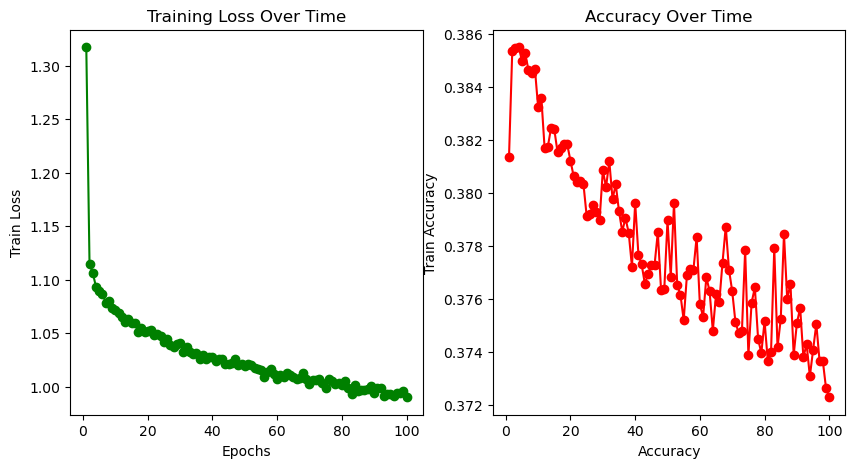

In [66]:
# plt.figure(figsize=(8, 6))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_hx_df['epoch'], train_hx_df['loss'], marker='o', color='g')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Train Loss')
axs[0].set_title('Training Loss Over Time')

axs[1].plot(train_hx_df['epoch'], train_hx_df['accuracy'], marker='o', color='r')
axs[1].set_xlabel('Accuracy')
axs[1].set_ylabel('Train Accuracy')
axs[1].set_title('Accuracy Over Time')

plt.show()

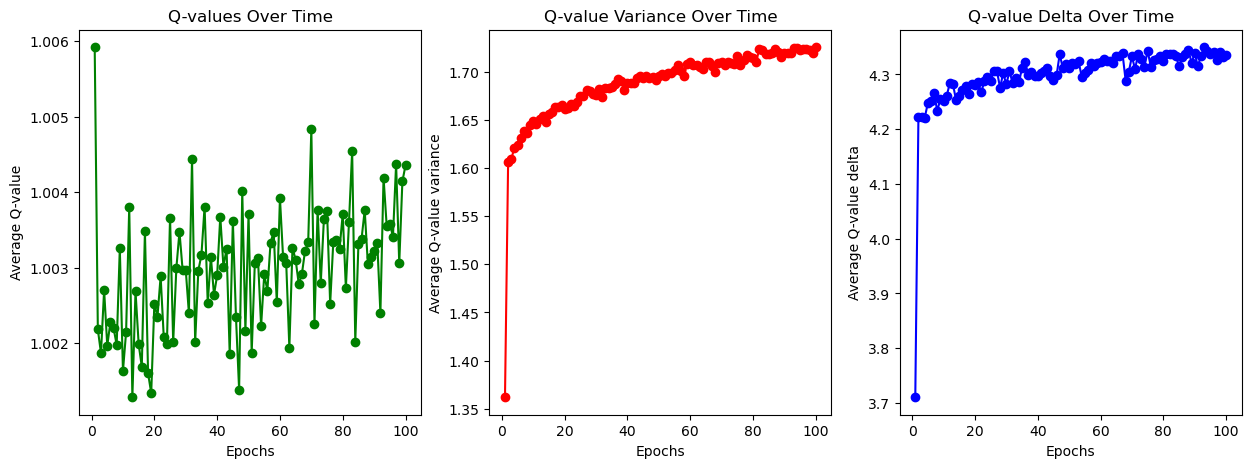

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(train_hx_df['epoch'], train_hx_df['avg_q_value'], marker='o', color='g')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Average Q-value')
axs[0].set_title('Q-values Over Time')

axs[1].plot(train_hx_df['epoch'], train_hx_df['avg_q_variance'], marker='o', color='r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Average Q-value variance')
axs[1].set_title('Q-value Variance Over Time')

axs[2].plot(train_hx_df['epoch'], train_hx_df['avg_max_q_delta'], marker='o', color='b')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Average Q-value delta')
axs[2].set_title('Q-value Delta Over Time')

plt.show()

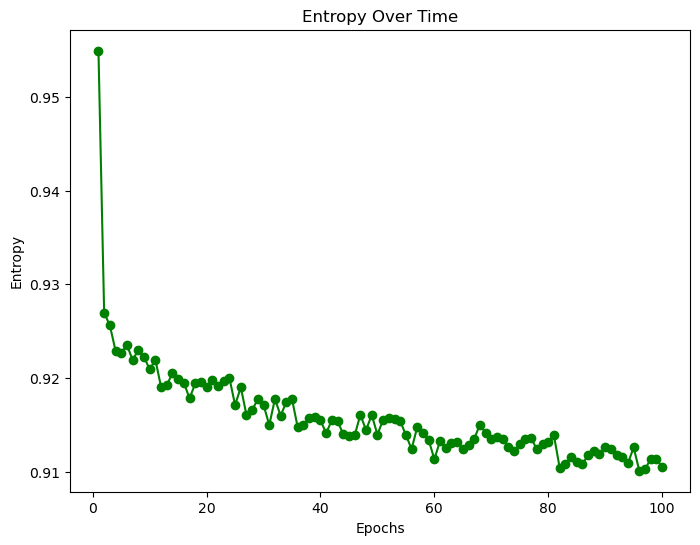

In [68]:
plt.figure(figsize=(8, 6))
plt.plot(train_hx_df['epoch'], train_hx_df['entropy'], marker='o', color='g')
plt.xlabel('Epochs')
plt.ylabel('Entropy')
plt.title('Entropy Over Time')
plt.show()

Test Loss: 2.8261
Avg Predicted Q-value: 1.0180
Avg Q-value Variance: 0.1529
Avg Q-value Delta: 0.1686
Avg Entropy: 3.0529
Accuracy: 0.0308


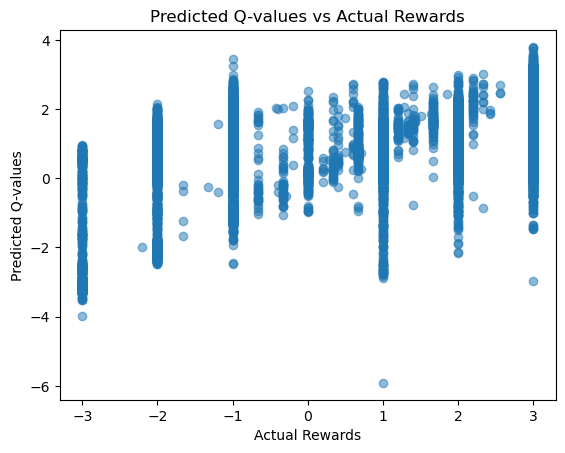

In [69]:
try:
    with open(os.path.join(data_dir, 'test_metrics.json'), 'r') as f:
        data = json.load(f)
except FileNotFoundError:
    print("Error: The file 'my_data.json' was not found.")

print(f"Test Loss: {data['avg_loss']:.4f}")
print(f"Avg Predicted Q-value: {data['avg_q_value']:.4f}")
print(f"Avg Q-value Variance: {data['avg_q_variance']:.4f}")
print(f"Avg Q-value Delta: {data['avg_max_q_change']:.4f}")
print(f"Avg Entropy: {data['avg_entropy']:.4f}")
print(f"Accuracy: {data['accuracy']:.4f}")

plt.scatter(data['total_rewards'], data['total_q_values'], alpha=0.5)
plt.xlabel("Actual Rewards")
plt.ylabel("Predicted Q-values")
plt.title("Predicted Q-values vs Actual Rewards")
plt.show()